In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

**1. Завантаження та попередня обробка набору даних:**

In [ ]:
#Гіперпараметри
random_seed = 42
learning_rate = 0.001
batch_size = 32
epochs = 20

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [ ]:
print(f'Train dataset {len(train_dataset)}')
print(f'Train dataloader {len(train_loader)}')

Train dataset 50000
Train dataloader 1563


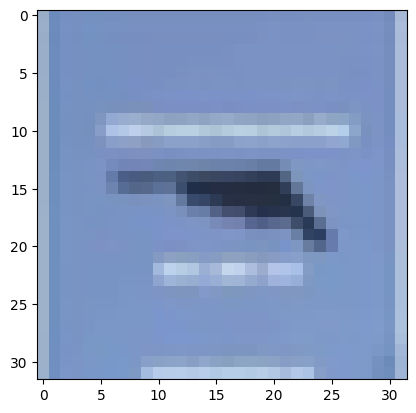

In [ ]:
r_i = (random.randrange(0,len(train_dataset)))
image, label = train_dataset[r_i]
single_img = np.array(image)
single_img_reshaped = np.transpose(np.reshape(single_img,(3, 32,32)), (1,2,0))
plt.imshow(single_img_reshaped)

**2. Створення архітектури VAE:**
  * Енкодер:
    * Побудуйте енкодер із згорткових шарів (Conv2D) для витягування просторових ознак.
    * Додайте кілька згорткових шарів з активацією ReLU або LeakyReLU.
    * Додайте два окремих вихідних шару для передбачення середнього значення (mean) та стандартного відхилення (logvar) для кожного виміру в латентному просторі.
  * Латентний простір:
    * Реалізуйте шар для вибірки з латентного простору, використовуючи mean та logvar, а також шум для генерації нових точок у латентному просторі.
  * Декодер:
    * Побудуйте декодер із згорткових транзитивних шарів (Conv2DTranspose) для відновлення зображень з латентного простору.
    * Використовуйте функцію активації ReLU або LeakyReLU у прихованих шарах і sigmoid або tanh для останнього шару, щоб згенерувати зображення в діапазоні [0, 1] або [-1, 1].

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self):
        super(Trim, self).__init__()

    def forward(self, x):
        return x[:, :, :32, :32]

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Енкодер: Додаємо кілька згорткових шарів з ReLU або LeakyReLU
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )

        self.linear_mean = nn.Linear(1024, 100)
        self.linear_logvar = nn.Linear(1024, 100)

        # Лінійний шар для перетворення латентного простору
        self.linear = nn.Linear(100, 1024)

        # Декодер: Використовуємо ReLU у прихованих шарах
        self.decoder = nn.Sequential(
            Reshape(-1, 256, 2, 2),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            Trim(),
            nn.Sigmoid()
        )

    def reparameterized(self, mean, var):
        eps = torch.randn(mean.size(0), mean.size(1)).to(mean.device)
        z = mean + eps * torch.exp(var / 2.)
        return z

    def encode(self, x):
        x = self.encoder(x)
        mean = self.linear_mean(x)
        var = self.linear_logvar(x)
        z = self.reparameterized(mean, var)
        return mean, var, z

    def decode(self, z):
        z = self.linear(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        mean, var, z = self.encode(x)
        z = self.decode(z)
        return mean, var, z

In [ ]:
# Перевірка моделі
from torchsummary import summary

vae = VAE().to(device)
x = torch.randn(1, 3, 32, 32).to(device)
vae(x)
summary(vae, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
         LeakyReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
         LeakyReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
         LeakyReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 2, 2]         295,168
         LeakyReLU-8            [-1, 256, 2, 2]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                  [-1, 100]         102,500
           Linear-11                  [-1, 100]         102,500
           Linear-12                 [-1, 1024]         103,424
          Reshape-13            [-1, 256, 2, 2]               0
  ConvTranspose2d-14            [-1, 12

**3. Налаштування функції втрат:**
  * Використайте комбінацію двох функцій втрат:
    * Реконструктивна втрата (binary cross-entropy або mean squared error) для порівняння відновлених зображень з оригінальними.
    * Kullback-Leibler (KL) дивергенція для регулювання латентного простору, щоб він мав нормальний розподіл.

**4. Навчання VAE:**
  * Навчіть модель на навчальній вибірці, оптимізуючи функцію втрат за допомогою оптимізатора, наприклад, Adam.
  * Моніторте загальні втрати, реконструктивну втрату та KL-дивергенцію на кожній епосі, щоб оцінити процес навчання.

In [ ]:
criterion = nn.MSELoss()
KL_weight = 0.000075
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [ ]:
train_losses_total, train_losses_total_avg = [], []
train_losses_reconstruction, train_losses_reconstruction_avg = [], []
train_losses_KL, train_losses_KL_avg = [], []

for epoch in range(epochs):

    train_loss_total = 0.0
    train_loss_reconstruction = 0.0
    train_loss_KL = 0.0

    for batch_idx, (images, _) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        mean, var, outputs = vae(images)

        optimizer.zero_grad()
        loss1 = criterion(outputs, images)
        loss2 = torch.mean(-0.5 * torch.sum(1 + var - mean**2 - torch.exp(var),axis=1),axis=0) # sum over latent dimension, not batch
        # -0.5 * torch.sum(1 + var - mean**2 - torch.exp(var), axis = 1).mean()
        # loss2 = torch.atan(loss2) / (np.pi / 2) # scaling it to [0,1]
        loss = loss1  + KL_weight * loss2
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            train_losses_reconstruction.append(loss1.item())
            train_losses_KL.append(loss2.item())
            train_losses_total.append(loss.item())
            train_loss_reconstruction += loss1.item() * images.size(0)
            train_loss_KL += loss2.item() * images.size(0)
            train_loss_total += loss.item() * images.size(0)

    train_loss_total /= len(train_loader)
    train_loss_reconstruction /= len(train_loader)
    train_loss_KL /= len(train_loader)

    train_losses_total_avg.append(train_loss_total)
    train_losses_reconstruction_avg.append(train_loss_reconstruction)
    train_losses_KL_avg.append(train_loss_KL)

    print('-----------------------------------------------------')
    print(f'Epoch{epoch + 1}')
    print(f'Total loss = {train_loss_total:.3f}')
    print(f'Reconstruction loss = {train_loss_reconstruction:.3f}, KL = {train_loss_KL:.3f}')

    log = {
        "epoch": epoch,
        "model_state": vae.state_dict(),
        "optimizer_state": optimizer.state_dict()
    }

    torch.save('./data/result/saved_model/', f'vae_log_{epoch + 1}.pth')

1563it [00:20, 74.99it/s] 


-----------------------------------------------------
Epoch1
Total loss = 0.781
Reconstruction loss = 0.681, KL = 1341.899


1563it [00:16, 96.92it/s] 


-----------------------------------------------------
Epoch2
Total loss = 0.557
Reconstruction loss = 0.435, KL = 1622.113


1563it [00:16, 96.63it/s] 


-----------------------------------------------------
Epoch3
Total loss = 0.524
Reconstruction loss = 0.392, KL = 1762.930


1563it [00:17, 91.48it/s] 


-----------------------------------------------------
Epoch4
Total loss = 0.510
Reconstruction loss = 0.372, KL = 1844.739


1563it [00:15, 98.09it/s] 


-----------------------------------------------------
Epoch5
Total loss = 0.501
Reconstruction loss = 0.358, KL = 1902.602


1563it [00:17, 91.86it/s]


-----------------------------------------------------
Epoch6
Total loss = 0.495
Reconstruction loss = 0.349, KL = 1943.337


1563it [00:16, 93.52it/s] 


-----------------------------------------------------
Epoch7
Total loss = 0.491
Reconstruction loss = 0.343, KL = 1971.350


1563it [00:16, 97.10it/s] 


-----------------------------------------------------
Epoch8
Total loss = 0.487
Reconstruction loss = 0.338, KL = 1996.589


1563it [00:16, 94.97it/s] 


-----------------------------------------------------
Epoch9
Total loss = 0.485
Reconstruction loss = 0.334, KL = 2014.632


1563it [00:16, 93.19it/s]


-----------------------------------------------------
Epoch10
Total loss = 0.482
Reconstruction loss = 0.330, KL = 2027.113


1563it [00:16, 96.67it/s] 


-----------------------------------------------------
Epoch11
Total loss = 0.481
Reconstruction loss = 0.328, KL = 2038.052


1563it [00:16, 93.02it/s] 


-----------------------------------------------------
Epoch12
Total loss = 0.479
Reconstruction loss = 0.325, KL = 2051.211


1563it [00:16, 92.41it/s]


-----------------------------------------------------
Epoch13
Total loss = 0.477
Reconstruction loss = 0.323, KL = 2061.539


1563it [00:16, 94.22it/s] 


-----------------------------------------------------
Epoch14
Total loss = 0.476
Reconstruction loss = 0.321, KL = 2072.821


1563it [00:16, 96.86it/s] 


-----------------------------------------------------
Epoch15
Total loss = 0.475
Reconstruction loss = 0.319, KL = 2082.029


1563it [00:16, 94.54it/s]


-----------------------------------------------------
Epoch16
Total loss = 0.474
Reconstruction loss = 0.318, KL = 2088.592


1563it [00:16, 93.86it/s] 


-----------------------------------------------------
Epoch17
Total loss = 0.473
Reconstruction loss = 0.316, KL = 2094.654


1563it [00:15, 98.07it/s] 


-----------------------------------------------------
Epoch18
Total loss = 0.472
Reconstruction loss = 0.315, KL = 2098.171


1563it [00:16, 97.50it/s] 


-----------------------------------------------------
Epoch19
Total loss = 0.472
Reconstruction loss = 0.314, KL = 2104.697


1563it [00:17, 90.31it/s]

-----------------------------------------------------
Epoch20
Total loss = 0.471
Reconstruction loss = 0.313, KL = 2110.167


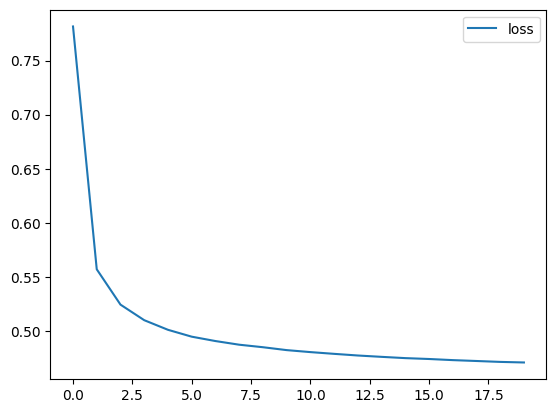

In [15]:
plt.plot(train_losses_total_avg, label='loss')
plt.legend()
plt.show()

**5. Генерація нових даних з латентного простору**

**6. Візуалізація результатів**

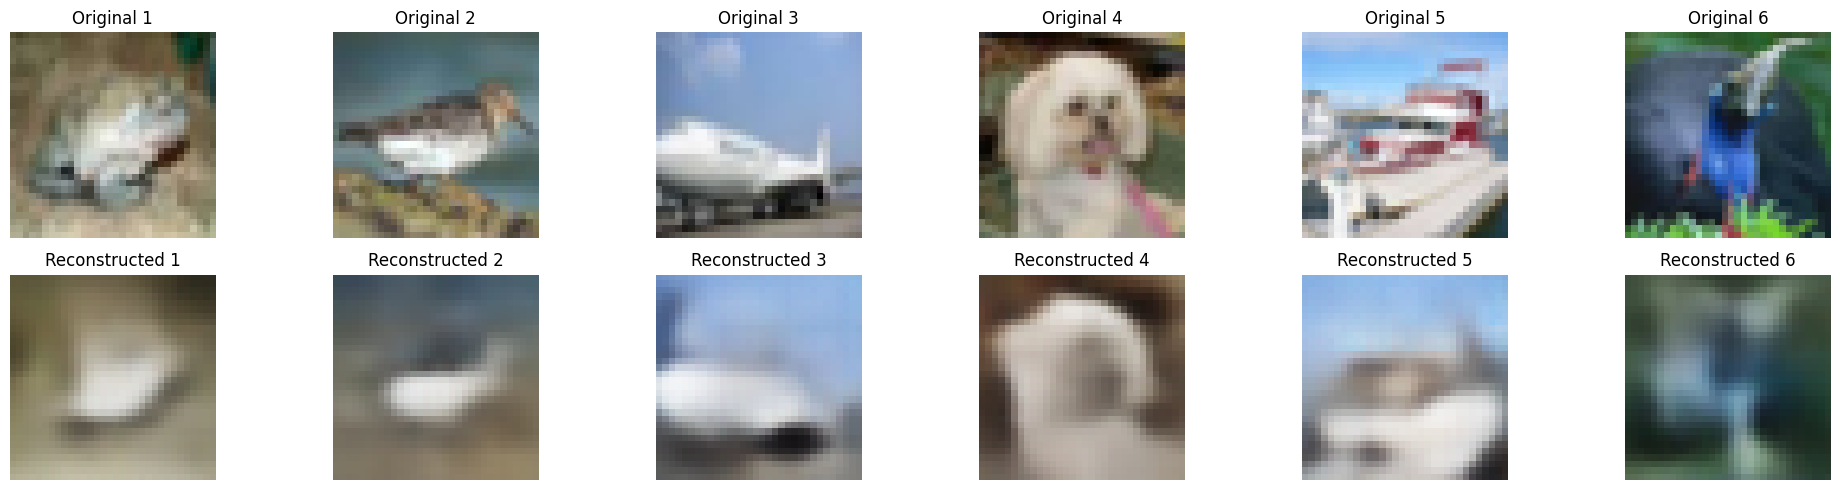

In [ ]:
data_iter = iter(train_loader)
images, _ = next(data_iter)  # `_` для міток, якщо вони є


fig, axs = plt.subplots(2, 6, figsize=(20, 5))


for i in range(6):
    axs[0][i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
    axs[0][i].axis('off')
    axs[0][i].set_title(f"Original {i + 1}")


_, _, new_fig = vae(images[:6].to(device))  # Взяти перші 6 зображень


for i in range(6):
    axs[1][i].imshow(new_fig[i].permute(1, 2, 0).cpu().detach().numpy())
    axs[1][i].axis('off')
    axs[1][i].set_title(f"Reconstructed {i + 1}")

plt.tight_layout()
plt.show()